# ทดสอบกระบวนการสร้างแบบจำลอง Regression ด้วย ML จาก Github Microsoft ใช้ Pipeline
https://github.com/MicrosoftDocs/ml-basics/blob/master/02%20-%20Regression.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Read and cleansing data

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events_mean_dBZ/df_org_dbz_rain_test120km.csv')
df.drop(df[df['rain_x'] <= 0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['rain_x'] < 1.0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['cappi1km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
#df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
#df.reset_index(drop=True)
#df.dropna(inplace=True)
df

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
6,NaN,NaN,NaN,NaN,2018-06-01-00:00,CTKN,10.8
28,NaN,NaN,NaN,NaN,2018-06-01-00:00,NMPR,3.6
72,22.267728,22.656334,23.252944,23.492632,2018-06-01-01:00,CMSG,0.4
107,37.450751,35.934908,34.647741,31.643592,2018-06-01-01:00,PIN004,0.2
138,28.847841,28.025389,26.520176,24.078056,2018-06-01-02:00,CMSG,0.2
...,...,...,...,...,...,...,...
68305,NaN,NaN,NaN,NaN,2018-09-21-18:00,CNDN,0.4
68328,NaN,NaN,NaN,NaN,2018-09-21-18:00,NAN005,1.0
68334,18.423027,18.423027,18.423027,NaN,2018-09-21-18:00,NGBA,0.8
68411,29.833809,NaN,NaN,NaN,2018-09-21-19:00,NAN013,24.8


In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
6,NaN,NaN,NaN,NaN,2018-06-01-00:00,CTKN,10.8
28,NaN,NaN,NaN,NaN,2018-06-01-00:00,NMPR,3.6
72,22.267728,22.656334,23.252944,23.492632,2018-06-01-01:00,CMSG,0.4
107,37.450751,35.934908,34.647741,31.643592,2018-06-01-01:00,PIN004,0.2
138,28.847841,28.025389,26.520176,24.078056,2018-06-01-02:00,CMSG,0.2
...,...,...,...,...,...,...,...
68305,NaN,NaN,NaN,NaN,2018-09-21-18:00,CNDN,0.4
68328,NaN,NaN,NaN,NaN,2018-09-21-18:00,NAN005,1.0
68334,18.423027,18.423027,18.423027,NaN,2018-09-21-18:00,NGBA,0.8
68411,29.833809,NaN,NaN,NaN,2018-09-21-19:00,NAN013,24.8


### คำนวณฝนประมาณค่าจากเรดาร์ค่าด้วย ZR Vectorized Operations:

In [4]:
#  Vectorized Operations:
constants = {
    'MP': (200, 1.6), # ZR marshall/palmer
    'RF': (250, 1.2), # ZR Rosenfeld
    'SC': (300, 1.4) # ZR Summer Deep Convection
}

for prefix, (a, b) in constants.items():
    for suffix in ['c1', 'c2', 'c3', 'c4']:
        dBZ_column = f'dBZ_{suffix}'
        rr_column = f'rr_{prefix}_{suffix}'
        df[rr_column] = ((10**(df[dBZ_column]/10.))/a)**(1/b)

In [5]:
#### ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
6,2018-06-01-00:00,CTKN,10.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2018-06-01-00:00,NMPR,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,2018-06-01-01:00,CMSG,0.4,0.898647,0.950336,1.035536,1.071879,0.720047,0.775791,0.869885,0.910827,0.662491,0.706216,0.779027,0.810350
107,2018-06-01-01:00,PIN004,0.2,7.989658,6.423741,5.337527,3.464023,13.262108,9.914991,7.745125,4.351938,8.047877,6.272011,5.075354,3.096594
138,2018-06-01-02:00,CMSG,0.2,2.316575,2.057989,1.657171,1.166097,2.545092,2.173530,1.628288,1.019111,1.955185,1.707816,1.333294,0.892255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68305,2018-09-21-18:00,CNDN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68328,2018-09-21-18:00,NAN005,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68334,2018-09-21-18:00,NGBA,0.8,0.516768,0.516768,0.516768,NaN,0.344325,0.344325,0.344325,NaN,0.352013,0.352013,0.352013,NaN
68411,2018-09-21-19:00,NAN013,24.8,2.669742,NaN,NaN,NaN,3.075158,NaN,NaN,NaN,2.299397,NaN,NaN,NaN


In [6]:
df.dropna(inplace=True)
df.reset_index(drop=True)

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01-01:00,CMSG,0.4,0.898647,0.950336,1.035536,1.071879,0.720047,0.775791,0.869885,0.910827,0.662491,0.706216,0.779027,0.810350
1,2018-06-01-01:00,PIN004,0.2,7.989658,6.423741,5.337527,3.464023,13.262108,9.914991,7.745125,4.351938,8.047877,6.272011,5.075354,3.096594
2,2018-06-01-02:00,CMSG,0.2,2.316575,2.057989,1.657171,1.166097,2.545092,2.173530,1.628288,1.019111,1.955185,1.707816,1.333294,0.892255
3,2018-06-01-02:00,NSRS,2.8,26.740589,25.118143,21.500539,16.534742,66.395140,61.078967,49.641029,34.976114,32.009071,29.799314,24.947083,18.478841
4,2018-06-01-03:00,CMSG,0.2,5.971266,4.801238,4.734323,5.353180,8.994911,6.725314,6.600631,7.775424,5.769704,4.496865,4.425311,5.092368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,2018-09-20-16:00,TGSK,0.8,0.871279,1.291773,1.794893,1.963920,0.690957,1.168127,1.811173,2.042083,0.639483,1.002976,1.460664,1.618897
2602,2018-09-20-17:00,PAS003,2.6,7.637749,6.846747,5.652252,4.423040,12.489034,10.794950,8.359949,6.028410,7.644055,6.746207,5.418789,4.094371
2603,2018-09-20-17:00,TGSK,0.2,0.816687,1.046085,1.194923,1.347858,0.633844,0.881721,1.052838,1.236234,0.593899,0.788103,0.917506,1.052896
2604,2018-09-21-14:00,PIN003,2.4,3.570917,3.593265,3.415970,2.660618,4.531911,4.569766,4.271631,3.061153,3.206039,3.228980,3.047550,2.290418


### รวมเป็นฝนรายวัน

In [7]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

aggregated_data.head()

,date_only,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01,BPPS,0.2,0.521811,0.537409,0.514784,0.728067,0.348813,0.362784,0.342564,0.543838,0.355941,0.368127,0.350468,0.520837
1,2018-06-01,CMSG,4.8,14.106057,12.901962,13.043754,13.905886,17.889174,15.588196,15.889232,17.639627,12.607459,11.306208,11.467976,12.430482
2,2018-06-01,KGKG,0.4,1.516191,1.607534,1.663254,1.650111,1.161252,1.245015,1.301619,1.285351,1.095590,1.167728,1.213664,1.201826
3,2018-06-01,KGLN,0.2,1.059222,1.063777,1.091251,1.158034,0.896515,0.901660,0.932841,1.009726,0.799424,0.803354,0.827109,0.885207
4,2018-06-01,KOKO,19.4,2.954353,2.936022,2.968597,3.049001,3.020454,3.010823,3.027016,3.069290,2.409088,2.396904,2.418280,2.472085


#### conditional rain
เป็นหนึ่งในกระบวนการ QC การจับคู่ของฝนเรดาร์กับฝนสถานี อ่านรายละเอียด
http://www.iapjournals.ac.cn/fileDQKXJZ/journal/article/dqkxjz/2012/3/PDF/110139.pdf

In [8]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_SC_c1']>0]
df_.reset_index(drop=True, inplace=True)
df_.describe()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
count,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000
mean,6.113693,5.294257,5.282567,5.494421,5.414796,7.472594,7.224511,7.627629,7.278537,4.870459,4.806281,5.027578,4.896828
std,9.200385,7.309392,6.802669,7.153162,7.030146,15.518386,13.537137,15.528479,14.731788,7.991783,7.224832,7.799579,7.512500
min,0.200000,0.155977,0.155977,0.138429,0.133181,0.069715,0.069715,0.059458,0.056472,0.089538,0.089538,0.078120,0.074745
25%,0.400000,1.074159,1.069515,1.067933,1.096747,0.828443,0.832788,0.869316,0.882518,0.777057,0.785722,0.789461,0.805399
50%,2.000000,2.603231,2.673188,2.775074,2.710776,2.388942,2.470662,2.607598,2.620812,2.061642,2.056311,2.210334,2.179168
75%,7.800000,6.327465,6.700708,7.315869,6.955144,7.091996,7.660960,8.257865,8.139516,5.296205,5.612195,6.165525,6.107616
max,77.800000,61.768699,53.932517,81.765849,85.743954,144.386842,122.695589,273.628624,291.291565,71.713940,61.500341,110.448859,116.576754


In [9]:
df_.corr()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
rain_truth,1.000000,0.552174,0.595816,0.573249,0.542107,0.451978,0.512756,0.453930,0.425369,0.512048,0.565442,0.530061,0.502001
rr_MP_c1,0.552174,1.000000,0.958486,0.870045,0.788381,0.953462,0.919005,0.766069,0.682142,0.989514,0.952385,0.840598,0.759315
rr_MP_c2,0.595816,0.958486,1.000000,0.923589,0.837562,0.880838,0.950457,0.798795,0.704687,0.932671,0.989190,0.885897,0.798084
rr_MP_c3,0.573249,0.870045,0.923589,1.000000,0.952593,0.779252,0.851520,0.929845,0.885427,0.836222,0.900901,0.985367,0.942186
rr_MP_c4,0.542107,0.788381,0.837562,0.952593,1.000000,0.675532,0.729008,0.861660,0.921293,0.741894,0.795899,0.925201,0.984712
rr_RF_c1,0.451978,0.953462,0.880838,0.779252,0.675532,1.000000,0.929454,0.757251,0.646197,0.986807,0.915206,0.788168,0.680991
rr_RF_c2,0.512756,0.919005,0.950457,0.851520,0.729008,0.929454,1.000000,0.813722,0.675221,0.935346,0.985556,0.855469,0.725652
rr_RF_c3,0.453930,0.766069,0.798795,0.929845,0.861660,0.757251,0.813722,1.000000,0.939590,0.771063,0.815893,0.978554,0.914471
rr_RF_c4,0.425369,0.682142,0.704687,0.885427,0.921293,0.646197,0.675221,0.939590,1.000000,0.672347,0.699418,0.923109,0.974510
rr_SC_c1,0.512048,0.989514,0.932671,0.836222,0.741894,0.986807,0.935346,0.771063,0.672347,1.000000,0.946257,0.825298,0.729602


## Feature selection

###  Correlation Analysis:

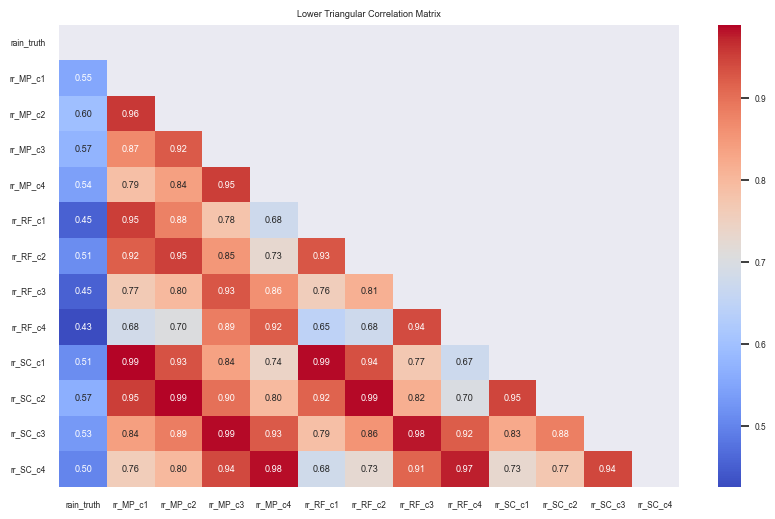

important_features_corr: ['rain_truth', 'rr_MP_c2', 'rr_MP_c3', 'rr_SC_c2', 'rr_MP_c1', 'rr_MP_c4', 'rr_SC_c3', 'rr_RF_c2', 'rr_SC_c1', 'rr_SC_c4', 'rr_RF_c3', 'rr_RF_c1', 'rr_RF_c4']


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_.corr()

# Create a mask for the lower triangular part
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the font scale for the heatmap
sns.set(font_scale=0.55)  # Adjust the font scale as needed

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title("Lower Triangular Correlation Matrix")
plt.show()

# Identify features highly correlated with the target
correlation_with_target = correlation_matrix['rain_truth'].abs().sort_values(ascending=False)
important_features_corr = correlation_with_target[correlation_with_target > 0.20].index.tolist()
print('important_features_corr:', important_features_corr)

## Preprocess data pipe line

In [11]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split
TargetVariable=['rain_truth']
#Predictors=['rr_RF_c1', 'dBZ_p1', 'rr_SC_c1', 'rr_RF_p1', 'dBZ_c1', 'rr_MP_c1']
#Predictors=['rr_MP_c3', 'rr_SC_c3', 'rr_MP_c2', 'rr_MP_c1']
#Predictors=['rr_SC_c3']
#Predictors=['rr_MP_c2', 'rr_MP_c3', 'rr_SC_c2', 'rr_MP_c1']
Predictors=['rr_MP_c2', 'rr_MP_c3', 'rr_SC_c2', 'rr_MP_c1', 'rr_MP_c4', 'rr_SC_c3']


X=df[Predictors].values
y=df[TargetVariable].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 1824 rows
Test Set: 782 rows


### Train the model : Ensemble model>GradientBoostingRegressor

In [12]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [0,1,2,3,4,5]
#numeric_features = [0,1,2,3]
#numeric_features = [0]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
#categorical_features = [4]
#categorical_transformer = Pipeline(steps=[
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])#,
        #('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

# Get predictions
predictions = model.predict(X_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', GradientBoostingRegressor())])


### ประเมินแบบจำลอง

MSE: 28.338246231928206
RMSE: 5.323367940686442
R2: -0.0068814206808778255


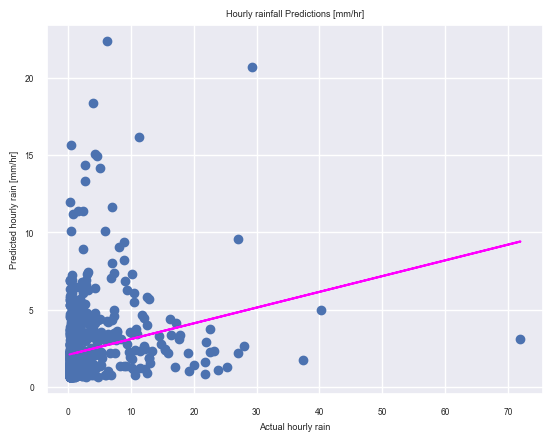

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## ฟังก์ชั่น density plot

In [14]:
def density_plot(y_test,predictions):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    # data
    x=y_test.transpose().flatten()
    y=predictions.flatten()

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50,cmap='jet')

    plt.xlabel('Actual hourly rain')
    plt.ylabel('Predicted hourly rain [mm/hr]')
    plt.title('Hourly rainfall Predictions [mm/hr]')
    z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
    p = np.poly1d(z)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='magenta', linewidth=2)
    #plt.plot(y_test,p(y_test), color='magenta')
    plt.show()

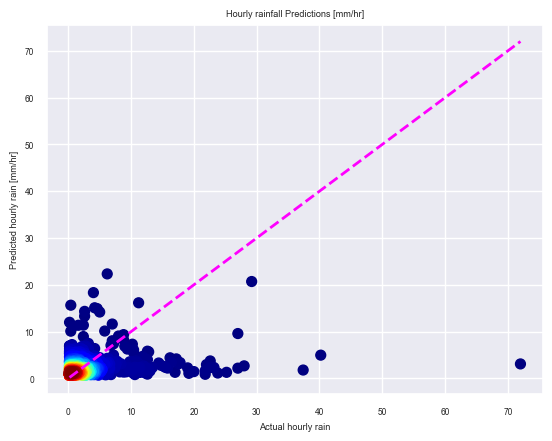

In [15]:
density_plot(y_test,predictions)

### try Train the model : Ensemble model > RandomForestRegressor

In [16]:
from sklearn.ensemble import RandomForestRegressor
# Use a different estimator in the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model, "\n")

# Get predictions
predictions = model.predict(X_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', RandomForestRegressor())]) 



### ประเมินแบบจำลอง

MSE: 28.732290608695656
RMSE: 5.360250983740935
R2: -0.020882144601608754


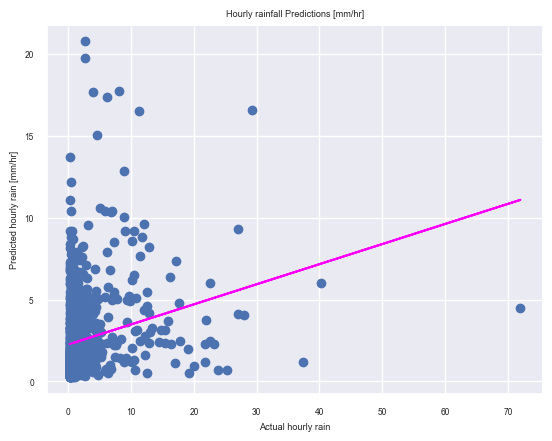

In [17]:
# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

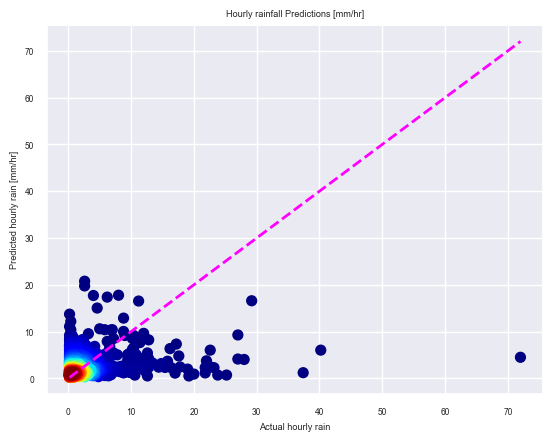

In [18]:
density_plot(y_test,predictions)

## Cross validation of pipeline with 3 แบบจำลอง แล้วตัดสินใจแบบจำลองที่ดีที่สุด

In [19]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [0, 1, 2, 3, 4, 5]
#numeric_features = [0, 1, 2, 3]
#numeric_features = [0]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Create a list of regressors
regressors = [
    ('GradientBoosting', GradientBoostingRegressor()),
    ('RandomForest', RandomForestRegressor()),
    ('DecisionTree', DecisionTreeRegressor())
]

# Define the number of folds for cross-validation
num_folds = 5

# Define scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error)
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)))
r2_scorer = make_scorer(r2_score)

# Define weights for each metric
#weights = {'mse': 0.4, 'mae': 0.2, 'rmse': 0.2, 'r2': 0.2}
weights = {'mse': 0.0, 'mae': 0.0, 'rmse': 0.50, 'r2': 0.50}

# Initialize variables to store composite scores
composite_scores = {}

# Loop through each regressor and calculate composite scores
for regressor_name, regressor in regressors:
    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

    # Perform k-fold cross-validation for the pipeline
    mse_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=mse_scorer)
    mae_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=mae_scorer)
    rmse_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=rmse_scorer)
    r2_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=r2_scorer)

    # Calculate average cross-validation scores
    avg_mse = -mse_scores.mean()
    avg_mae = mae_scores.mean()
    avg_rmse = rmse_scores.mean()
    avg_r2 = r2_scores.mean()

    # Calculate composite score
    composite_score = (
        weights['mse'] * avg_mse +
        weights['mae'] * avg_mae +
        weights['rmse'] * avg_rmse +
        weights['r2'] * avg_r2
    )

    # Store composite score for each regressor
    composite_scores[regressor_name] = composite_score

# Print the composite scores for each model
for regressor_name, score in composite_scores.items():
    print(f"{regressor_name} Composite Score: {score:.4f}")

# Decide which model is the best based on the composite scores
best_model = max(composite_scores, key=composite_scores.get)
print(f"The best model is {best_model}.")

GradientBoosting Composite Score: 2.0647
RandomForest Composite Score: 2.0769
DecisionTree Composite Score: 2.0370
The best model is RandomForest.


## Cross validation of pipeline with 5 แบบจำลอง แล้วตัดสินใจแบบจำลองที่ดีที่สุด

In [20]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [0, 1, 2, 3, 4, 5]
#numeric_features = [0, 1, 2, 3]
#numeric_features = [0]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Create a list of regressors
regressors = [
    ('LinearRegression', LinearRegression()),
    ('Lasso', Lasso()),
    ('GradientBoosting', GradientBoostingRegressor()),
    ('RandomForest', RandomForestRegressor()),
    ('DecisionTree', DecisionTreeRegressor())
]

# Define the number of folds for cross-validation
num_folds = 5

# Define scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error)
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)))
r2_scorer = make_scorer(r2_score)

# Define weights for each metric
weights = {'mse': 0.0, 'mae': 0.0, 'rmse': 0.50, 'r2': 0.50}
#weights = {'mse': 0.25, 'mae': 0.25, 'rmse': 0.25, 'r2': 0.25}
#weights = {'mse': 0.4, 'mae': 0.2, 'rmse': 0.2, 'r2': 0.2}
#weights = {'mse': 0.0, 'mae': 0.0, 'rmse': 1.0, 'r2': 0.0}

# Initialize variables to store composite scores
composite_scores = {}

# Loop through each regressor and calculate composite scores
for regressor_name, regressor in regressors:
    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

    # Perform k-fold cross-validation for the pipeline
    mse_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=mse_scorer)
    mae_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=mae_scorer)
    rmse_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=rmse_scorer)
    r2_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring=r2_scorer)

    # Calculate average cross-validation scores
    avg_mse = -mse_scores.mean()
    avg_mae = mae_scores.mean()
    avg_rmse = rmse_scores.mean()
    avg_r2 = r2_scores.mean()

    # Calculate composite score
    composite_score = (
        weights['mse'] * avg_mse +
        weights['mae'] * avg_mae +
        weights['rmse'] * avg_rmse +
        weights['r2'] * avg_r2
    )

    # Store composite score for each regressor
    composite_scores[regressor_name] = composite_score

# Print the composite scores for each model
for regressor_name, score in composite_scores.items():
    print(f"{regressor_name} Composite Score: {score:.4f}")

# Decide which model is the best based on the composite scores
best_model = max(composite_scores, key=composite_scores.get)
print(f"The best model is {best_model}.")


LinearRegression Composite Score: 2.0622
Lasso Composite Score: 2.0750
GradientBoosting Composite Score: 2.0726
RandomForest Composite Score: 2.0651
DecisionTree Composite Score: 2.0100
The best model is Lasso.


### plot graph results of CV models

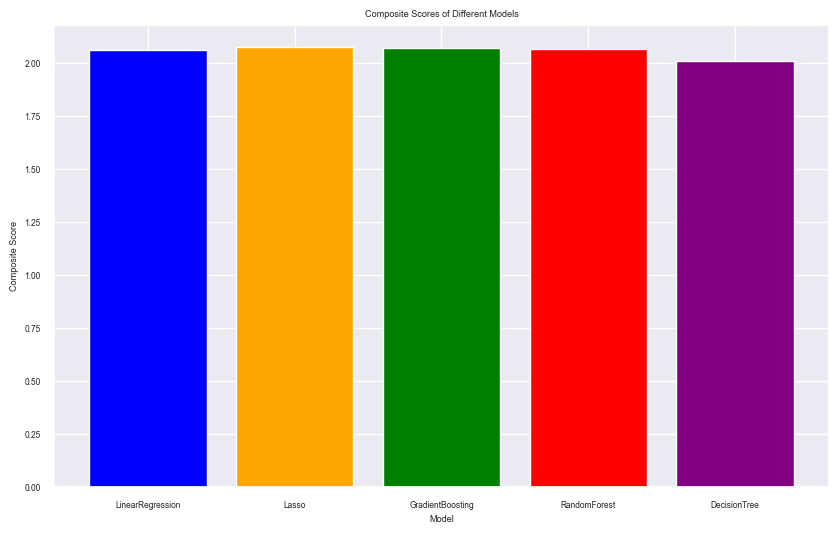

In [21]:
import matplotlib.pyplot as plt

# Extract model names and composite scores
model_names = list(composite_scores.keys())
composite_scores_values = list(composite_scores.values())

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, composite_scores_values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title("Composite Scores of Different Models")
plt.xlabel("Model")
plt.ylabel("Composite Score")
plt.show()

### validation plot for the best model: LinearRegression

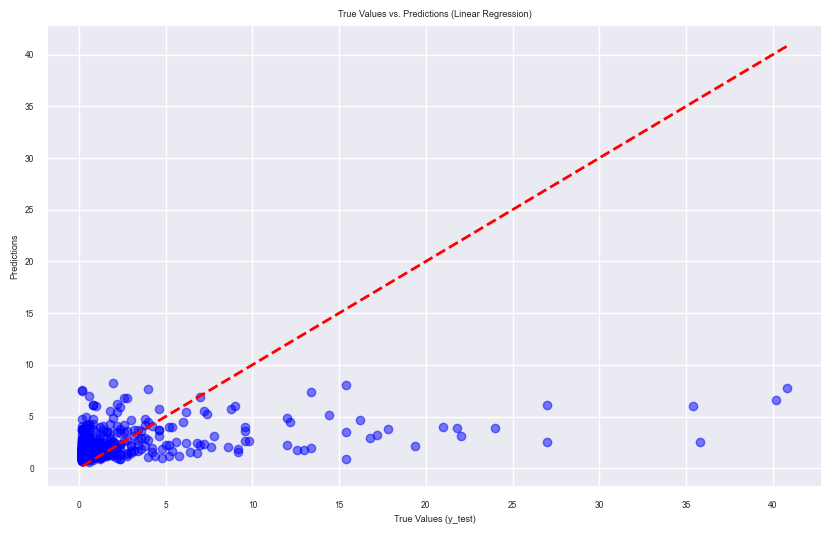

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = linear_reg_model.predict(X_test)

# Plot the scatter plot of true values vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.title("True Values vs. Predictions (Linear Regression)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions")

# Plot the fitted line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

plt.show()


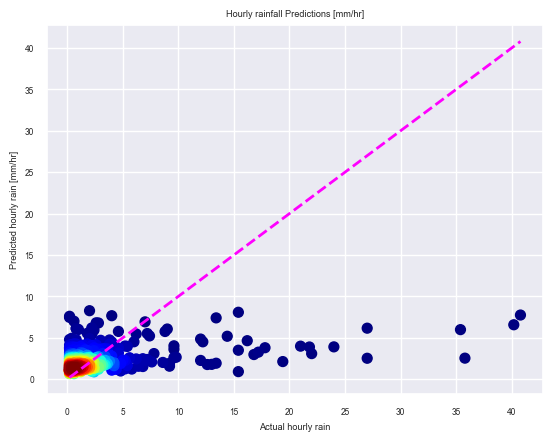

In [23]:
density_plot(y_test,predictions)

###  validation plot for the RandomForestRegressor

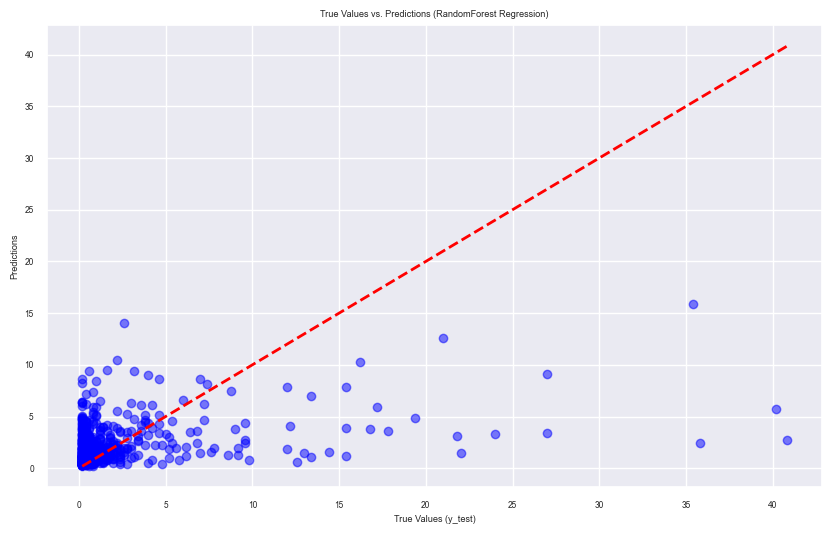

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
RandomForest_reg_model = RandomForestRegressor()
RandomForest_reg_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = RandomForest_reg_model.predict(X_test)

# Plot the scatter plot of true values vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.title("True Values vs. Predictions (RandomForest Regression)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions")

# Plot the fitted line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

plt.show()


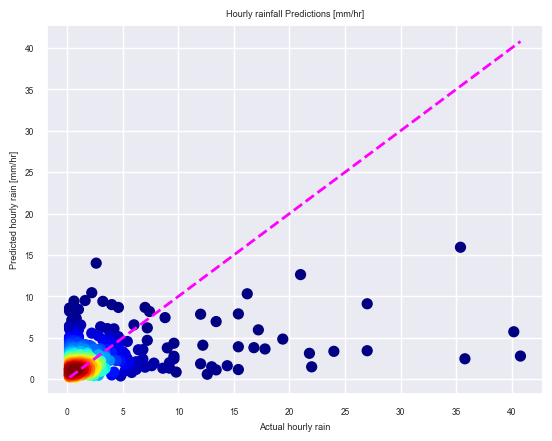

In [25]:
density_plot(y_test,predictions)

###  validation plot for the GradientBoostingRegressor

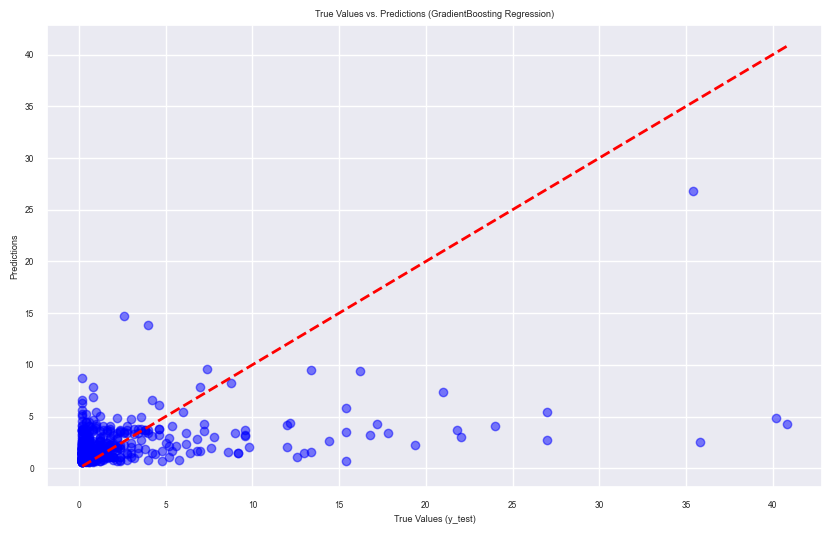

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
GradientBoosting_reg_model = GradientBoostingRegressor()
GradientBoosting_reg_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = GradientBoosting_reg_model.predict(X_test)

# Plot the scatter plot of true values vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.title("True Values vs. Predictions (GradientBoosting Regression)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions")

# Plot the fitted line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

plt.show()

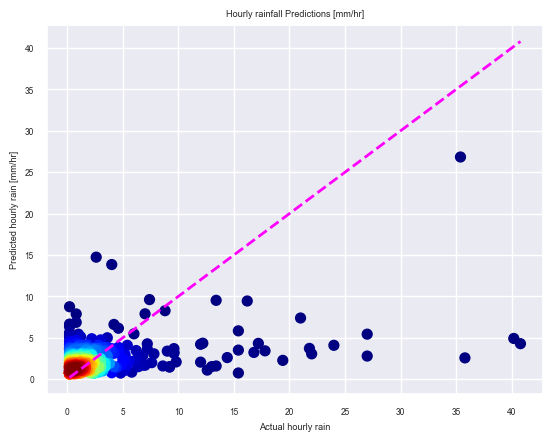

In [27]:
density_plot(y_test,predictions)

## Optimization: Hyperparameter tuning


### ทดสอบกับ GradientBoostingRegressor

#### score ใช้ r2

Best parameter combination: {'learning_rate': 0.12005192452767675, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.12005192452767675, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=50, subsample=0.8) 

MSE: 20.89582700981003
RMSE: 4.571195358963564
R2: 0.13829629779149744
Correlation coefficient (r): 0.3790686058671751
P-value: 2.7787839532582267e-19


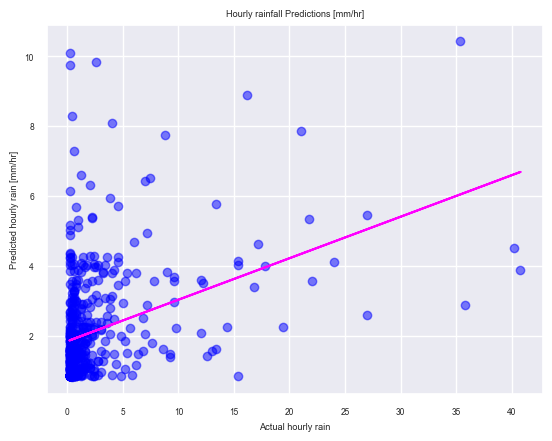

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import linregress

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': uniform(0.01, 1.0),
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV with 'r2' as the scoring parameter
score = 'r2'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density

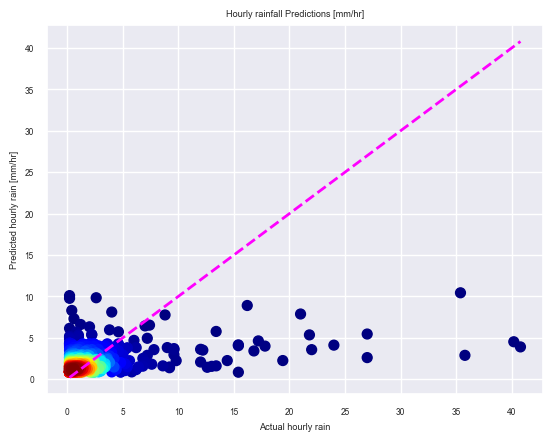

In [29]:
density_plot(y_test,predictions)

#### score ใช้ rmse

Best parameter combination: {'learning_rate': 0.12005192452767675, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.12005192452767675, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=50, subsample=0.8) 

MSE: 20.298055441310453
RMSE: 4.505336329433182
R2: 0.16294724716092146
Correlation coefficient (r): 0.4240138126885294
P-value: 3.415573136448218e-24


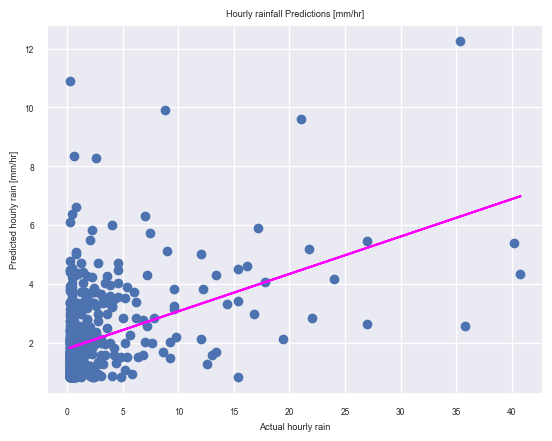

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': uniform(0.01, 1.0),
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density

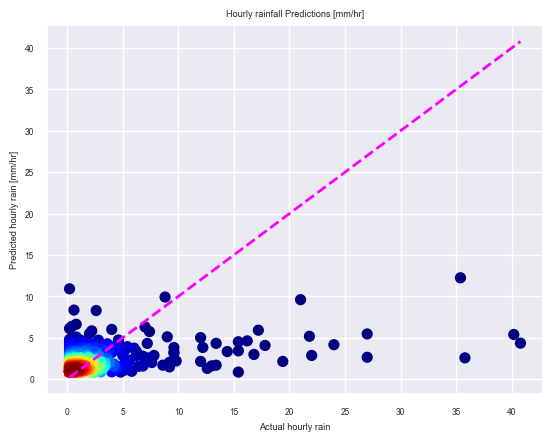

In [31]:
density_plot(y_test,predictions)

### ทดสอบกับ RandomForest

Best parameter combination: {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 108} 

RandomForestRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=108) 

MSE: 20.2823379283385
RMSE: 4.503591669805168
R2: 0.16359540715531096
Correlation coefficient (r): 0.43473331405353455
P-value: 1.7717232107077164e-25


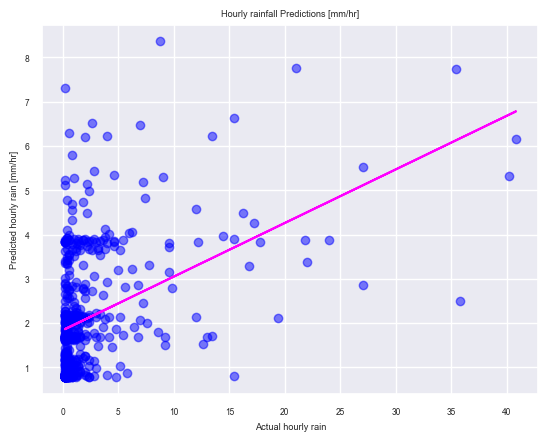

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

# Use a Random Forest algorithm
alg = RandomForestRegressor()

# Define the hyperparameter search space
params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density plot

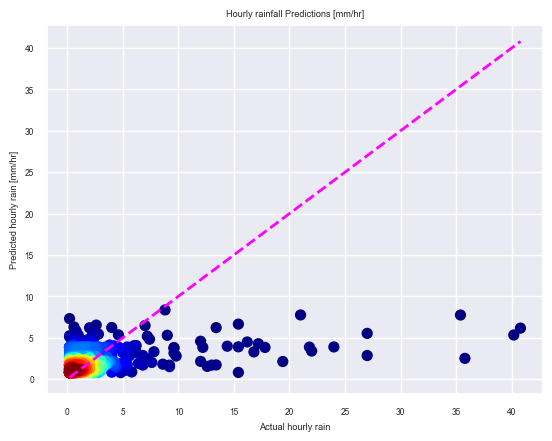

In [33]:
density_plot(y_test,predictions)

### ทดสอบกับ Decision Tree

Best parameter combination: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'splitter': 'random'} 

DecisionTreeRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=6,
                      splitter='random') 

MSE: 20.363106126439412
RMSE: 4.512549847529599
R2: 0.16026468206404798
Correlation coefficient (r): 0.4222697101294546
P-value: 5.473085802811816e-24


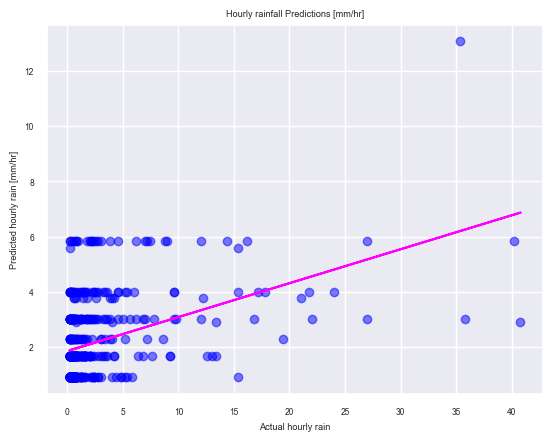

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

# Use a Decision Tree algorithm
alg = DecisionTreeRegressor()

# Define the hyperparameter search space
params = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'splitter': ['best', 'random']
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density plot

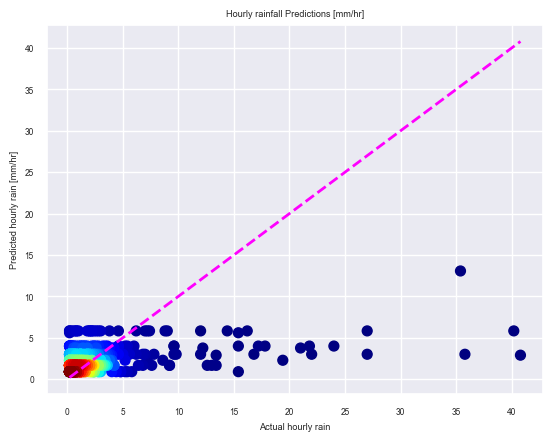

In [35]:
density_plot(y_test,predictions)

### ทดสอบกับ Linear Regression

Best parameter combination: {'normalize': True, 'n_jobs': -1, 'fit_intercept': True, 'copy_X': True} 

LinearRegression(n_jobs=-1, normalize=True) 

MSE: 20.357414388527076
RMSE: 4.511919146940365
R2: 0.16049939838462035
Correlation coefficient (r): 0.426576706935198
P-value: 1.6997640136838752e-24


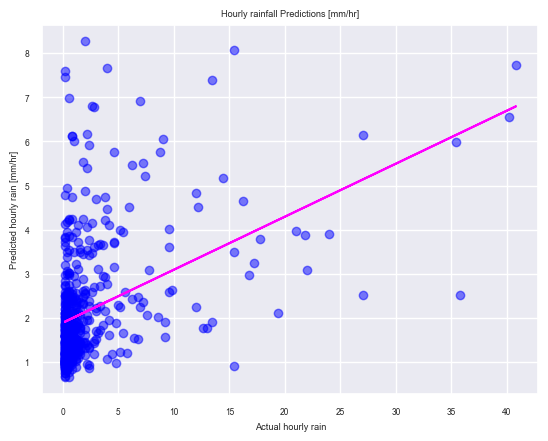

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Use a Linear Regression algorithm
alg = LinearRegression()

# Define the hyperparameter search space
params = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1, 1]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model = random_search.best_estimator_
print(best_model, "\n")

# Evaluate the model using the test data
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


### พลอต density

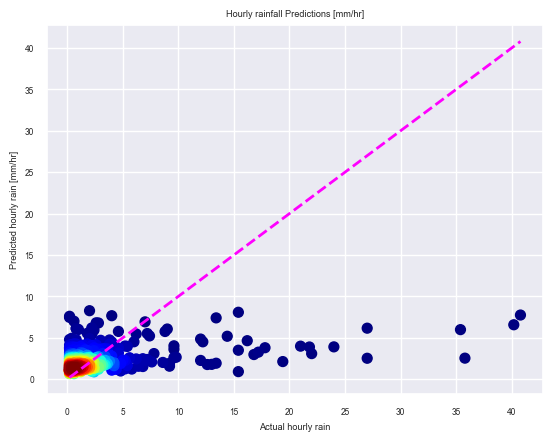

In [37]:
density_plot(y_test,predictions)

### Xgboost

Best parameter combination: {'subsample': 0.9, 'reg_lambda': 10, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8} 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...) 

MSE: 20.990973486533644
RMSE: 4.581590715737673
R2: 0.13437264015371453
Correlation coefficient (r): 0.41234823798477305
P-value: 7

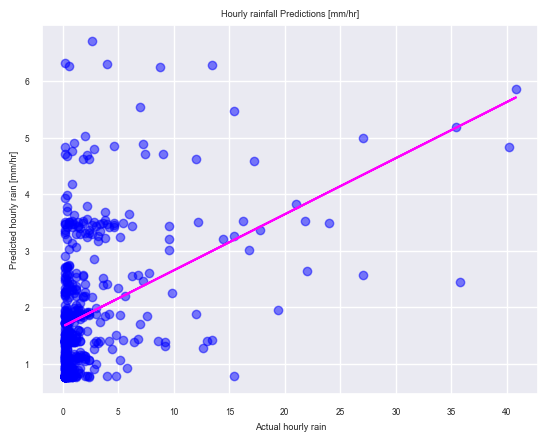

In [38]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

# Use XGBoost algorithm
xgb_model = xgb.XGBRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0, 1, 10]
}

# Use RandomizedSearchCV or GridSearchCV for hyperparameter tuning
# RandomizedSearchCV example
from sklearn.model_selection import RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(xgb_model, params, n_iter=50, scoring='r2', cv=5, random_state=42, return_train_score=True)
random_search_xgb.fit(X_train, y_train)

print("Best parameter combination:", random_search_xgb.best_params_, "\n")

# Get the best model
best_xgb_model = random_search_xgb.best_estimator_
print(best_xgb_model, "\n")

# Evaluate the model using the test data
predictions_xgb = best_xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, predictions_xgb)
print("MSE:", mse_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print("RMSE:", rmse_xgb)
r2_xgb = r2_score(y_test, predictions_xgb)
print("R2:", r2_xgb)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions_xgb.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions_xgb, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions_xgb.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()


###  Support Vector Machines (SVM) 


In [39]:
'''
# รันนานมาก
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

# Use SVR algorithm
svm_model = SVR()

# Define the hyperparameter search space
params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.3]
}

# Use RandomizedSearchCV or GridSearchCV for hyperparameter tuning
# RandomizedSearchCV example
from sklearn.model_selection import RandomizedSearchCV
random_search_svm = RandomizedSearchCV(svm_model, params, n_iter=50, scoring='r2', cv=5, random_state=42, return_train_score=True)
random_search_svm.fit(X_train, y_train)

print("Best parameter combination:", random_search_svm.best_params_, "\n")

# Get the best model
best_svm_model = random_search_svm.best_estimator_
print(best_svm_model, "\n")

# Evaluate the model using the test data
predictions_svm = best_svm_model.predict(X_test)
mse_svm = mean_squared_error(y_test, predictions_svm)
print("MSE:", mse_svm)
rmse_svm = np.sqrt(mse_svm)
print("RMSE:", rmse_svm)
r2_svm = r2_score(y_test, predictions_svm)
print("R2:", r2_svm)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions_svm.flatten())
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions_svm, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions_svm.flatten(), 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()
'''

'\n# รันนานมาก\nfrom sklearn.svm import SVR\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom scipy.stats import linregress\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Use SVR algorithm\nsvm_model = SVR()\n\n# Define the hyperparameter search space\nparams = {\n    \'kernel\': [\'linear\', \'poly\', \'rbf\'],\n    \'C\': [0.1, 1, 10],\n    \'gamma\': [\'scale\', \'auto\'],\n    \'epsilon\': [0.1, 0.2, 0.3]\n}\n\n# Use RandomizedSearchCV or GridSearchCV for hyperparameter tuning\n# RandomizedSearchCV example\nfrom sklearn.model_selection import RandomizedSearchCV\nrandom_search_svm = RandomizedSearchCV(svm_model, params, n_iter=50, scoring=\'r2\', cv=5, random_state=42, return_train_score=True)\nrandom_search_svm.fit(X_train, y_train)\n\nprint("Best parameter combination:", random_search_svm.best_params_, "\n")\n\n# Get the best model\nbest_svm_model = random_search_svm.best_estimator_\nprint(best_svm_model, "\n")\n\n# Evaluate the model using the test data\n

### a neural network for regression tasks using TensorFlow and Keras

In [40]:
'''
# ทำใน google colab ได้
# error น่าจะติดตั้ง tensorflow ไม่สำเร็จ
#ต้องติดตั้ง TensorFlow ให้ได้ก่อน

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network model
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)  # Output layer, no activation for regression
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

# Build the model
nn_model = build_model()

# Train the model
history = nn_model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)

# Evaluate the model using the test data
predictions_nn = nn_model.predict(X_test).flatten()
mse_nn = mean_squared_error(y_test, predictions_nn)
print("MSE:", mse_nn)
rmse_nn = np.sqrt(mse_nn)
print("RMSE:", rmse_nn)
r2_nn = r2_score(y_test, predictions_nn)
print("R2:", r2_nn)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions_nn)
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions_nn, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions_nn, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()
'''

'\n# error น่าจะติดตั้ง tensorflow ไม่สำเร็จ\n#ต้องติดตั้ง TensorFlow ให้ได้ก่อน\n\nimport tensorflow as tf\nfrom tensorflow import keras\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom scipy.stats import linregress\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Define the neural network model\ndef build_model():\n    model = keras.Sequential([\n        keras.layers.Dense(64, activation=\'relu\', input_shape=(X_train.shape[1],)),\n        keras.layers.Dense(64, activation=\'relu\'),\n        keras.layers.Dense(1)  # Output layer, no activation for regression\n    ])\n    \n    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)\n    \n    model.compile(loss=\'mean_squared_error\',\n                  optimizer=optimizer,\n                  metrics=[\'mean_absolute_error\', \'mean_squared_error\'])\n    return model\n\n# Build the model\nnn_model = build_model()\n\n# Train the model\nhistory = nn_model.fit(X_train, y_train, epochs=100, validation_split=0.

### ตัวอย่างการ optimize ANN

In [41]:
'''
# ทำใน google colab ได้
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

# Define the neural network model
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32),
                                  activation='relu', input_shape=(X_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                                      activation='relu'))
        
    model.add(keras.layers.Dense(1))  # Output layer, no activation for regression
    
    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

# Instantiate the Keras Tuner RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Total number of optimization attempts
    executions_per_trial=3,  # Number of models to train and evaluate for each trial
    directory='keras_tuner',
    project_name='neural_network_regression'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
best_model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)

# Evaluate the best model using the test data
predictions = best_model.predict(X_test).flatten()
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Calculate p-value and correlation coefficient (r)
slope, intercept, r_value, p_value, std_err = linregress(y_test.flatten(), predictions)
print(f'Correlation coefficient (r): {r_value}')
print(f'P-value: {p_value}')

# Plot predicted vs actual
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.xlabel('Actual hourly rain')
plt.ylabel('Predicted hourly rain [mm/hr]')
plt.title('Hourly rainfall Predictions [mm/hr]')
# overlay the regression line
z = np.polyfit(y_test.flatten(), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')
plt.show()

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters:")
print(best_hyperparameters.values)

# Get the best model's architecture
best_model.summary()

'''


'\n\nimport tensorflow as tf\nfrom tensorflow import keras\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom scipy.stats import linregress\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom kerastuner.tuners import RandomSearch\n\n# Define the neural network model\ndef build_model(hp):\n    model = keras.Sequential()\n    model.add(keras.layers.Dense(units=hp.Int(\'units_input\', min_value=32, max_value=512, step=32),\n                                  activation=\'relu\', input_shape=(X_train.shape[1],)))\n    \n    for i in range(hp.Int(\'num_layers\', 1, 3)):\n        model.add(keras.layers.Dense(units=hp.Int(f\'units_{i}\', min_value=32, max_value=512, step=32),\n                                      activation=\'relu\'))\n        \n    model.add(keras.layers.Dense(1))  # Output layer, no activation for regression\n    \n    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice(\'learning_rate\', values=[1e-2, 1e-3, 1e-4]))\n    \n    model.compile(loss=\'

### optimize architecture ANN

In [ ]:
'''
# ทำใน google colab ได้
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network model with customizable architecture
def build_model(num_layers=1, units_per_layer=64, dropout_rate=0.0, l2_regularization=0.0):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=units_per_layer, activation='relu', input_shape=(X_train.shape[1],)))
    
    # Add hidden layers with customizable parameters
    for _ in range(num_layers):
        model.add(keras.layers.Dense(units=units_per_layer, activation='relu'))
        if dropout_rate > 0.0:
            model.add(keras.layers.Dropout(dropout_rate))
        if l2_regularization > 0.0:
            model.add(keras.layers.Dense(units=units_per_layer, kernel_regularizer=keras.regularizers.l2(l2_regularization), activation='relu'))
    
    # Output layer
    model.add(keras.layers.Dense(1))  # Output layer, no activation for regression
    
    # Compile the model
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

# Define parameters for experimentation
num_layers = [1, 2, 3]  # Number of hidden layers
units_per_layer = [32, 64, 128]  # Units per hidden layer
dropout_rates = [0.0, 0.1, 0.2]  # Dropout rates
l2_regularizations = [0.0, 0.01, 0.1]  # L2 regularization parameters

# Perform experiments
results = []

for num_layer in num_layers:
    for units in units_per_layer:
        for dropout_rate in dropout_rates:
            for l2_reg in l2_regularizations:
                # Build the model
                model = build_model(num_layers=num_layer, units_per_layer=units, dropout_rate=dropout_rate, l2_regularization=l2_reg)
                
                # Train the model
                history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)
                
                # Evaluate the model
                predictions = model.predict(X_test).flatten()
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test, predictions)
                
                # Save results
                results.append((num_layer, units, dropout_rate, l2_reg, mse, rmse, r2))

# Find the best model based on metrics
best_model_results = min(results, key=lambda x: x[4])  # Minimum MSE
print("Best Model Results:")
print("Number of Layers:", best_model_results[0])
print("Units per Layer:", best_model_results[1])
print("Dropout Rate:", best_model_results[2])
print("L2 Regularization:", best_model_results[3])
print("MSE:", best_model_results[4])
print("RMSE:", best_model_results[5])
print("R2:", best_model_results[6])
'''

## สังเกต
ฝนรายชั่วโมง จาก dBZ ให้ค่าไม่ดี ควรทดสอบ
* ใช้ค่า zr แปลงเป็นฝน แล้วทำการ aggegrate เวลา เป็นรายวัน แล้วทำการหาแบบจำลองที่จะทำนายฝนรายวันจากเรดาร์ตรวจอากาศให้ได้ แต่ทดสอบหาความสัมพันธ์ระหว่างฝนเรดาร์ กับ ฝนภาคพื้นดิน 1, 3, 6, 12, 24 ชั่วโมงดูก่อน ว่าอันไหนดีสุด แล้วค่อยเลือกช่วงเวลาที่สั้นที่สุด มาทำการสร้างแบบจำลอง เล่นกับมุมยกเดียวก่อน cappi 1 km แล้วค่อยๆ เพิ่ม